### Import des lib

In [46]:
import csv
import os
from pathlib import Path

import torch
from torch import Tensor
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from typing import Dict, List, Tuple, Union

from torch.utils.data import Dataset,DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchaudio.transforms import MelSpectrogram
import torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Dataset
#### Création d'un custom dataset pour les données audio qui permette de convertir les fichiers audio en en waveform
Documentation Pytorch pour le dataset Common Voice de Mozilla adapté pour le format du dataset segment word

In [47]:
def load_commonvoice_item(
    line: List[str], header: List[str], path: str, folder_audio: str, ext_audio: str
) -> Tuple[Tensor, int, Dict[str, str]]:
    # Each line as the following data:
    # client_id, path, sentence, up_votes, down_votes, age, gender, accent

    if header[1] != "path":
        raise ValueError(f"expect `header[1]` to be 'path', but got {header[1]}")
    fileid = line[1]
    filename = os.path.join(path, folder_audio, fileid)
    if not filename.endswith(ext_audio):
        filename += ext_audio
    waveform, sample_rate = torchaudio.load(filename)

    dic = dict(zip(header, line))
    return waveform, sample_rate, dic

class COMMONVOICE(Dataset):
    _ext_audio = ".mp3"
    _folder_audio = "clips"

    def __init__(self, root: Union[str, Path], tsv: str = "train.tsv", transform=None):
        self._path = os.fspath(root)
        self._tsv = os.path.join(self._path, tsv)
        with open(self._tsv, "r") as tsv_:
            walker = csv.reader(tsv_, delimiter="\t")
            self._header = next(walker)
            self._walker = [row for row in walker if row[self._header.index('sentence')] not in  ['Hey','Firefox','zéro','cinq','six','sept','huit','neuf', 'oui','non']]
        self.transform = transform or MelSpectrogram()

    def __getitem__(self, n: int) -> Tuple[torch.Tensor, str]:
        line = self._walker[n]
        waveform, _, dic = load_commonvoice_item(line, self._header, self._path, self._folder_audio, self._ext_audio)
        spectrogram = self.transform(waveform).squeeze(0)  # Apply transformation and remove channel dim
        label = dic["sentence"]
        return spectrogram, label

    def __len__(self) -> int:
        return len(self._walker)


transform = MelSpectrogram(sample_rate=48000, n_mels=40, n_fft=512, hop_length=256)

train_dataset = COMMONVOICE(root="./data/cv-corpus-7.0-singleword/fr", tsv="train.tsv", transform=transform)
test_dataset = COMMONVOICE(root="./data/cv-corpus-7.0-singleword/fr", tsv="test.tsv", transform=transform)


### On va faire un peu d'analyse sur notre cas 

In [48]:
print(len(train_dataset))
print(len(test_dataset))


2476
1633


train_dataset[0]

In [49]:
print(f"Type: {type(train_dataset[0])}")
print(f"Len: {len(train_dataset[0])}")
print(f"Information: {train_dataset[0]}")

Type: <class 'tuple'>
Len: 2
Information: (tensor([[1.7347e-17, 4.0429e-14, 1.2759e-13,  ..., 1.3268e-08, 2.5376e-10,
         8.7066e-15],
        [1.4316e-17, 4.5047e-14, 1.0819e-13,  ..., 2.0457e-08, 5.3971e-10,
         2.2737e-14],
        [3.1239e-18, 4.2344e-14, 6.3341e-14,  ..., 2.9987e-08, 1.2690e-09,
         5.3724e-14],
        ...,
        [3.7121e-20, 1.7319e-17, 3.5030e-17,  ..., 9.4666e-14, 6.9060e-14,
         2.3212e-15],
        [1.0889e-22, 3.0891e-21, 1.0275e-19,  ..., 3.5403e-17, 5.6377e-18,
         5.8499e-19],
        [3.4923e-23, 1.1659e-21, 1.0599e-19,  ..., 2.0608e-17, 4.8907e-18,
         2.3140e-19]]), 'trois')


### Information train set

In [50]:
print("----------------------------------\nInformation test_dataset[0][0] (spectrogram) 2 dim")
print(f"Type: {type(train_dataset[2000][0])}")
print(f"Len: {len(train_dataset[2000][0])}")
print(train_dataset[2000][0].shape)
print(train_dataset[2000][0])

print("\n----------------------------------\nInformation train_dataset[0][1]")
print(type(train_dataset[2000][1]))
print(train_dataset[2000][1])

print("\n----------------------------------\nInformation train_dataset[0][0][0]")
print(f"Type: {type(train_dataset[2000][0][0])}")
print(f"Len: {len(train_dataset[2000][0][0])}")
print(f"Shape: {train_dataset[2000][0][0].shape}")


----------------------------------
Information test_dataset[0][0] (spectrogram) 2 dim
Type: <class 'torch.Tensor'>
Len: 40
torch.Size([40, 347])
tensor([[4.9696e-18, 1.6902e-15, 1.2306e-13,  ..., 7.3587e-07, 5.7591e-06,
         3.1783e-06],
        [4.4137e-18, 2.0254e-14, 2.7674e-13,  ..., 3.6807e-06, 7.7680e-06,
         3.5848e-06],
        [2.0248e-18, 6.8738e-14, 4.7718e-13,  ..., 8.6291e-06, 1.7162e-05,
         3.2527e-06],
        ...,
        [5.6878e-24, 1.9430e-22, 9.5982e-21,  ..., 4.1816e-13, 4.2136e-13,
         1.3651e-12],
        [5.9575e-24, 1.1512e-22, 1.1138e-20,  ..., 2.7564e-13, 5.2790e-13,
         1.8132e-12],
        [1.0310e-23, 1.1297e-22, 1.0687e-20,  ..., 3.7662e-13, 3.4585e-13,
         2.5475e-12]])

----------------------------------
Information train_dataset[0][1]
<class 'str'>
quatre

----------------------------------
Information train_dataset[0][0][0]
Type: <class 'torch.Tensor'>
Len: 347
Shape: torch.Size([347])


### Information test Set

In [51]:
print("----------------------------------\nInformation test_dataset[0][0] (spectrogram) 2 dim")
print(f"Type: {type(test_dataset[0][0])}")
print(f"Len: {len(test_dataset[0][0])}")
print(test_dataset[0][0].shape)
print(test_dataset[0][0])

print("\n----------------------------------\nInformation test_dataset[0][1]")
print(type(test_dataset[0][1]))
print(test_dataset[0][1])

print("\n----------------------------------\nInformation test_dataset[0][0][0]")
print(f"Type: {type(test_dataset[0][0][0])}")
print(f"Len: {len(test_dataset[0][0][0])}")
print(f"Shape: {test_dataset[0][0][0].shape}")


----------------------------------
Information test_dataset[0][0] (spectrogram) 2 dim
Type: <class 'torch.Tensor'>
Len: 40
torch.Size([40, 586])
tensor([[1.0754e-22, 3.3921e-17, 7.2511e-16,  ..., 3.5823e-03, 3.8992e-04,
         7.6389e-05],
        [1.0576e-22, 3.3387e-17, 8.1298e-16,  ..., 3.8282e-03, 8.5377e-04,
         1.3530e-04],
        [7.2006e-23, 1.8899e-17, 6.6264e-16,  ..., 2.8965e-03, 1.5084e-03,
         2.5431e-04],
        ...,
        [1.3781e-26, 6.8235e-25, 2.0681e-24,  ..., 1.7314e-12, 7.8913e-12,
         3.2655e-08],
        [5.6890e-27, 2.6357e-25, 8.8249e-25,  ..., 2.6694e-13, 3.2489e-13,
         7.3257e-09],
        [6.6815e-27, 2.1177e-25, 1.1318e-24,  ..., 2.1353e-13, 2.9736e-13,
         3.9848e-09]])

----------------------------------
Information test_dataset[0][1]
<class 'str'>
trois

----------------------------------
Information test_dataset[0][0][0]
Type: <class 'torch.Tensor'>
Len: 586
Shape: torch.Size([586])


### Premier spectrogram: test_dataset[0][0]
- taille première dim = 40 = nbr de filtre mel
- taille deuxième dim = 586 = unité temporelle du fichier audio 
##### Tensor premier échantillon temporel"test_dataset[0][0][0]
- len = 586

### Premier Label: test_dataset[0][1]

### Valeur max pour padding 
On va donc trouver la valeur max de la len de [x][0][0]<br>
Ca va représenter notre plus grande valeur temporelle et donc on va pouvoir faire un padding sur ça

In [52]:
max_train = 0
for i in range(len(train_dataset)):
    if len(train_dataset[i][0][0]) > max_train:
        max_train = len(train_dataset[i][0][0])

max_test = 0
for i in range(len(test_dataset)):
    if len(test_dataset[i][0][0]) > max_test:
        print(i)
        max_test = len(test_dataset[i][0][0])

overall_max = max_test if max_test > max_train else max_train

0
6
8
34
35
57
297


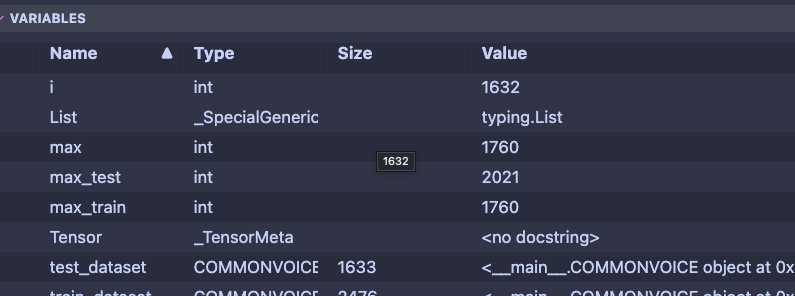

In [53]:
def pad_tensor(spectrogram, max_width):
    # spectrogram shape: [n_mels, time]
    current_width = spectrogram.shape[1]
    if current_width < max_width:
        # Calculate how much padding is needed at the end
        padding_needed = max_width - current_width
        # Pad the spectrogram
        # Pad format (left, right, top, bottom) for 2D tensor
        padded_spectrogram = F.pad(spectrogram, (0, padding_needed))
    else:
        padded_spectrogram = spectrogram
    return padded_spectrogram

In [54]:
class COMMONVOICE_PADDED(Dataset):
    _ext_audio = ".mp3"
    _folder_audio = "clips"

    def __init__(self, root: Union[str, Path], tsv: str = "train.tsv", transform=None, padding_size=overall_max):
        self._path = os.fspath(root)
        self._tsv = os.path.join(self._path, tsv)
        self.padding_size = padding_size
        with open(self._tsv, "r") as tsv_:
            walker = csv.reader(tsv_, delimiter="\t")
            self._header = next(walker)
            self._walker = [row for row in walker if row[self._header.index('sentence')] not in  ['Hey','Firefox','zéro','cinq','six','sept','huit','neuf', 'oui','non']]
        self.transform = transform or MelSpectrogram()

    def __getitem__(self, n: int) -> Tuple[torch.Tensor, str]:
        line = self._walker[n]
        waveform, _, dic = load_commonvoice_item(line, self._header, self._path, self._folder_audio, self._ext_audio)
        spectrogram = self.transform(waveform).squeeze(0)  # Apply transformation and remove channel dim
        spectrogram = pad_tensor(spectrogram, self.padding_size)
        # spectrogram = spectrogram.transpose(0, 1)
        label = dic["sentence"]
        return spectrogram, label

    def __len__(self) -> int:
        return len(self._walker)


transform = MelSpectrogram(sample_rate=48000, n_mels=40, n_fft=512, hop_length=256)

train_dataset = COMMONVOICE_PADDED(root="./data/cv-corpus-7.0-singleword/fr", tsv="train.tsv", transform=transform, padding_size=overall_max)
test_dataset = COMMONVOICE_PADDED(root="./data/cv-corpus-7.0-singleword/fr", tsv="test.tsv", transform=transform, padding_size=overall_max)


In [55]:
print(train_dataset[0][0].shape)

torch.Size([40, 2021])


In [56]:
print("----------------------------------\nInformation test_dataset[0][0] (spectrogram) 2 dim")
print(f"Type: {type(test_dataset[0][0])}")
print(f"Len: {len(test_dataset[0][0])}")
print(test_dataset[0][0].shape)
print(test_dataset[0][0])

print("\n----------------------------------\nInformation test_dataset[0][1]")
print(type(test_dataset[0][1]))
print(test_dataset[0][1])

print("\n----------------------------------\nInformation test_dataset[0][0][0]")
print(f"Type: {type(test_dataset[0][0][0])}")
print(f"Len: {len(test_dataset[0][0][0])}")
print(f"Shape: {test_dataset[0][0][0].shape}")

----------------------------------
Information test_dataset[0][0] (spectrogram) 2 dim
Type: <class 'torch.Tensor'>
Len: 40
torch.Size([40, 2021])
tensor([[1.0754e-22, 3.3921e-17, 7.2511e-16,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0576e-22, 3.3387e-17, 8.1298e-16,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.2006e-23, 1.8899e-17, 6.6264e-16,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.3781e-26, 6.8235e-25, 2.0681e-24,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.6890e-27, 2.6357e-25, 8.8249e-25,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.6815e-27, 2.1177e-25, 1.1318e-24,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

----------------------------------
Information test_dataset[0][1]
<class 'str'>
trois

----------------------------------
Information test_dataset[0][0][0]
Type: <class 'torch.Tensor'>
Len: 2021
Shape: torch.Size([2021])


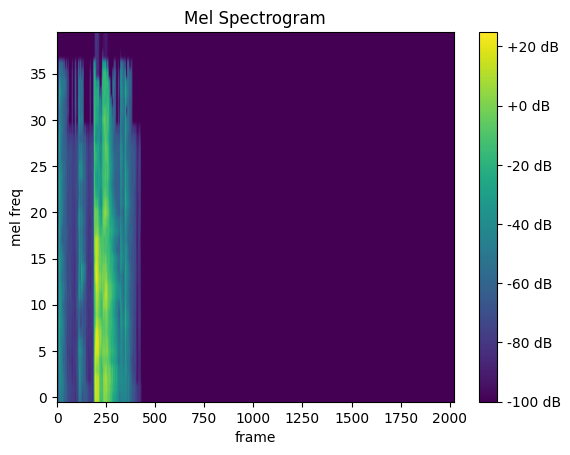

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
def plot_spectrogram(spectrogram, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    """
    Plots a spectrogram.
    
    Parameters:
        spectrogram (Tensor): A spectrogram with shape [Frequency, Time].
        title (str, optional): Title of the plot.
        ylabel (str, optional): Label of the y-axis.
        aspect (str, optional): Aspect ratio of the plot.
        xmax (int, optional): Maximum value of the x-axis.
    """
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (dB)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spectrogram, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    axs.set_yscale('linear')
    fig.colorbar(im, ax=axs, format="%+2.0f dB")
    plt.show(block=False)

spectrogram_db = torchaudio.transforms.AmplitudeToDB()(train_dataset[297][0])
plot_spectrogram(spectrogram_db.numpy(), title='Mel Spectrogram', ylabel='mel freq')


In [58]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(4536, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)  
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [59]:

train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)


cnn = SimpleCNN(num_classes=4)

In [60]:
map_test = {
    'un': 0,
    'deux': 1,
    'trois': 2,
    'quatre': 3,
    # 'oui': 4,
    # 'non': 5,
}

def train(model, train_data_loader, optimizer, criterion):
    model.train()
    for epoch in range(5):
        for batch_idx, (spectrograms, labels) in enumerate(train_data_loader):
            optimizer.zero_grad()
            outputs =  model(torchaudio.transforms.AmplitudeToDB()(spectrograms))
            labels = torch.tensor([map_test[label] for label in labels], dtype=torch.long)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1}: Loss: {loss.item()}")
        
optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# train(cnn, train_data_loader, optimizer, criterion)

In [61]:
def test(model, test_data_loader):
    acc_total = 0
    model.eval()
    for spectrograms, labels in test_data_loader:
        outputs = model(torchaudio.transforms.AmplitudeToDB()(spectrograms))
        _, predicted = torch.max(outputs, 1)
        labels = torch.tensor([map_test[label] for label in labels], dtype=torch.long)
        acc_total += (predicted==labels).sum().item()/len(labels)
    print(f"Accuracy: {acc_total/len(test_data_loader)}")

# test(cnn, test_data_loader)

In [62]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=0.5 if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Hidden cells
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # Cell states
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Out: tensor of shape (batch_size, seq_length, hidden_dim)
        out, _ = self.lstm(x, (h0, c0))  

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [64]:
input_dim = 2021
hidden_dim = 256
num_layers = 2
num_classes = 4
lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes)
output = lstm(train_dataset[0][0].unsqueeze(0))
print(output)

tensor([[ 0.0365,  0.0224, -0.0014,  0.0534]], grad_fn=<AddmmBackward0>)


In [65]:
tensor = train_dataset[0][0]  # Assuming this is your spectrogram tensor
print("Original tensor shape:", tensor.shape)

# Unsqueeze to add a batch dimension
input_tensor = tensor.unsqueeze(0)
print("Unsqueezed tensor shape:", input_tensor.shape)

# Now pass to LSTM
output = lstm(input_tensor)
print("Model output:", output)

Original tensor shape: torch.Size([40, 2021])
Unsqueezed tensor shape: torch.Size([1, 40, 2021])
Model output: tensor([[0.0349, 0.0103, 0.0024, 0.0619]], grad_fn=<AddmmBackward0>)


In [66]:
train(lstm, train_data_loader, optimizer, criterion)

Epoch 1: Loss: 1.3972713947296143
Epoch 2: Loss: 1.391454815864563
Epoch 3: Loss: 1.396141767501831
Epoch 4: Loss: 1.392049789428711
Epoch 5: Loss: 1.3899887800216675


In [ ]:
test(lstm, test_data_loader)

Accuracy: 0.24918831168831168
